In [ ]:
pip install botorch

In [2]:
import pandas as pd
import torch

#import random
#random.seed(0)
#import numpy as np
#np.random.seed(0)

train_data = pd.read_excel('data_sample_multiple_components_withoutAverage_GLU_9objs_iter00.xlsx')
#print(train_data)
train_x = train_data.iloc[:,[0,1]].values
#print(train_X)
train_x = torch.tensor(train_x, dtype=torch.float32)
print(train_x)

train_obj = train_data.iloc[:,2:].values
#print(train_Y)
train_obj = torch.tensor(train_obj, dtype=torch.float32)
print(train_obj)

tensor([[0.0050, 0.5000],
        [0.0050, 0.5000],
        [0.0050, 0.5000],
        [0.0050, 1.0000],
        [0.0050, 1.0000],
        [0.0050, 1.0000],
        [0.0050, 2.0000],
        [0.0050, 2.0000],
        [0.0050, 2.0000],
        [0.0406, 0.5000],
        [0.0406, 0.5000],
        [0.0406, 0.5000],
        [0.0406, 1.0000],
        [0.0406, 1.0000],
        [0.0406, 1.0000],
        [0.0406, 2.0000],
        [0.0406, 2.0000],
        [0.0406, 2.0000]])
tensor([[ 0.0450,  0.0500,  0.0090,  0.0190,  0.1520,  0.0000,  0.0210,  0.0270,
         -0.1990],
        [ 0.0390,  0.0540,  0.0130,  0.0640,  0.1800,  0.0000,  0.0260,  0.0210,
         -0.1990],
        [ 0.0470,  0.0660,  0.0140,  0.0280,  0.2280,  0.0000,  0.0330,  0.0400,
         -0.1990],
        [ 0.0500,  0.0480,  0.0110,  0.0180,  0.2010,  0.0000,  0.0220,  0.0270,
         -0.3740],
        [ 0.0510,  0.0610,  0.0200,  0.0220,  0.2160,  0.0000,  0.0290,  0.0180,
         -0.3870],
        [ 0.0490,  0.0580,  0.0

In [3]:
from botorch import fit_gpytorch_model
from botorch.models.gp_regression import FixedNoiseGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch.utils.transforms import unnormalize, normalize
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.optim.optimize import optimize_acqf

torch.manual_seed(0)

NOISE_SE = torch.tensor([1,1,1,1,1,1,1,1,1])
#print(NOISE_SE)

# define models for objective and constraint
models = []
for i in range(train_obj.shape[-1]):
    train_y = train_obj[..., i:i+1]
    train_yvar = torch.full_like(train_y, NOISE_SE[i] ** 2)
    models.append(FixedNoiseGP(train_x, train_y, train_yvar, outcome_transform=Standardize(m=1)))
model = ModelListGP(*models)
mll = SumMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll)

BATCH_SIZE = 10
NUM_RESTARTS = 2
RAW_SAMPLES = 4
MC_SAMPLES = 16

standard_bounds = torch.tensor([[0.001, 0.1],[0.05, 3]])
#print(standard_bounds)
ref_point=torch.tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0])

with torch.no_grad():
  #pred = model.posterior(normalize(train_x, standard_bounds)).mean
  pred = model.posterior(train_x).mean
partitioning = FastNondominatedPartitioning(ref_point, Y=pred)
sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
acq_func = qExpectedHypervolumeImprovement(model,ref_point,partitioning,sampler)

candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        #options={"batch_limit": 5, "maxiter": 200},
        sequential=True)
#candidates =  unnormalize(candidates.detach(), bounds=standard_bounds)
print(candidates)

/usr/local/lib/python3.7/dist-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


tensor([[1.8542e-02, 8.3327e-01],
        [1.3619e-02, 2.5995e+00],
        [1.9970e-02, 2.2111e-01],
        [4.4772e-02, 2.0989e+00],
        [3.1184e-02, 1.0067e+00],
        [1.2088e-03, 3.8620e-01],
        [4.0980e-03, 6.6677e-01],
        [4.7046e-02, 1.7213e+00],
        [3.3898e-02, 2.4039e+00],
        [9.6460e-03, 2.4084e+00]])


In [4]:
selected_candidates_idx = [9,1,2,8,7]
selected_candidates = candidates[selected_candidates_idx]
print(selected_candidates)
pred = model.posterior(selected_candidates).mean.squeeze().detach().numpy()
print(pred)

ground_truth_data = pd.read_excel('data_sample_multiple_components_withoutAverage_GLU_9objs_iter01.xlsx')
gt_x = ground_truth_data.iloc[-5:,[0,1]].values
gt_x = torch.tensor(gt_x, dtype=torch.float32)
print(gt_x)

gt_y = ground_truth_data.iloc[-5:,2:].values
gt_y = torch.tensor(gt_y, dtype=torch.float32)
print(gt_y)

tensor([[0.0096, 2.4084],
        [0.0136, 2.5995],
        [0.0200, 0.2211],
        [0.0339, 2.4039],
        [0.0470, 1.7213]])
[[ 0.05000317  0.05932309  0.01594462  0.02338119  0.205843    0.01160961
   0.02299945  0.02494497 -0.3979014 ]
 [ 0.05000149  0.05932849  0.01594452  0.02338525  0.20583747  0.0116104
   0.02299974  0.02494469 -0.38730225]
 [ 0.04999349  0.05934315  0.01594427  0.0234049   0.20567149  0.01161203
   0.02300096  0.0249463  -0.34577024]
 [ 0.05000324  0.05932296  0.01594462  0.02338107  0.20584254  0.01160968
   0.02299943  0.02494496 -0.3982584 ]
 [ 0.05000513  0.05931895  0.01594469  0.0233765   0.20587252  0.01160935
   0.02299913  0.02494472 -0.4084224 ]]
tensor([[0.0096, 2.4084],
        [0.0136, 2.5995],
        [0.0200, 0.2211],
        [0.0339, 2.4039],
        [0.0470, 1.7213]])
tensor([[ 0.0289,  0.0235,  0.0175,  0.0123,  0.0977,  0.0000,  0.0141,  0.0129,
         -0.1088],
        [ 0.0391,  0.0331,  0.0195,  0.0155,  0.1298,  0.0000,  0.0188,  

In [7]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
rmse = mean_squared_error(gt_y, pred, multioutput='raw_values',squared=False)
print(rmse)
mae = mean_absolute_error(gt_y, pred, multioutput='raw_values')
print(mae)

[0.01477667 0.02670222 0.00560607 0.00835146 0.4852509  0.01472206
 0.00546874 0.00847088 0.246488  ]
[0.013159   0.0260962  0.00483475 0.00787463 0.2812662  0.01400563
 0.0050379  0.00823323 0.24214515]


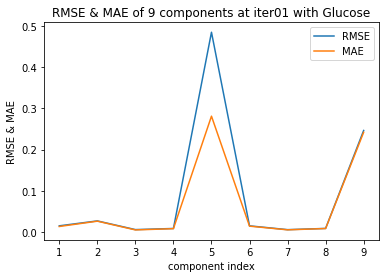

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([1,2,3,4,5,6,7,8,9])
plt.plot(x, rmse, label='RMSE')
plt.plot(x, mae, label='MAE')
plt.title("RMSE & MAE of 9 components at iter01 with Glucose")
plt.xlabel("component index")
plt.ylabel("RMSE & MAE")
plt.legend()
plt.show()
